In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

device

device(type='mps')

In [10]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    #v2.ToDtype(torch.float32), 
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

train_dataset = datasets.ImageFolder(root='catdog_data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='catdog_data/test', transform=transform)
validation_dataset = datasets.ImageFolder(root='catdog_data/validation', transform=transform)

print('train size:', len(train_dataset))
print('test size:', len(test_dataset))
print('validation size:', len(validation_dataset))

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=128, shuffle=True)

train size: 2000
test size: 400
validation size: 600


tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1])
torch.Size([128, 3, 128, 128]) torch.Size([128])


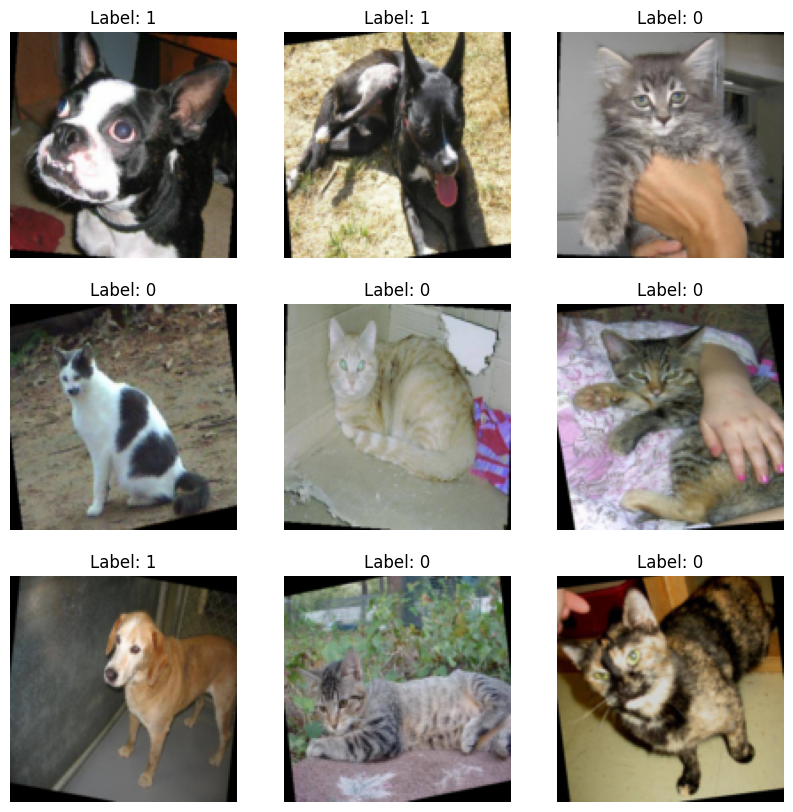

In [11]:
sample_images, sample_labels = next(iter(train_loader))
print(sample_labels)
print(sample_images.shape, sample_labels.shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.title(f'Label: {sample_labels[i]}')
    plt.axis('off')
plt.show()

# Model Definition

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)       # 3 input channels (RGB), 32 output channels
        self.conv2 = nn.Conv2d(32, 64, 3, 1)      # 64 output channels
        self.pool = nn.MaxPool2d(2, 2)            # Max pooling layer with 2x2 kernel
        self.dropout = nn.Dropout(0.25)           # Dropout layer with 25% dropout rate

        self.fc1 = nn.Linear(64 * 30 * 30, 128)   
        self.fc2 = nn.Linear(128, 2)              # 2 output nodes for binary classification

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 30 * 30)
        x = torch.relu(self.fc1(x))               
        x = self.dropout(x)                       # Apply dropout for regularization
        x = self.fc2(x)                           # Output layer

        return x


In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()

        # Define the feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # Conv Layer 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),           # Conv Layer 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),          # Conv Layer 3
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # Conv Layer 4
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),          # Conv Layer 5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 3*3, 4096),                          # Fully Connected Layer 1
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096),                                 # Fully Connected Layer 2
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)                           # Output Layer
        )

    def forward(self, x):
        with torch.no_grad():
             x = self.features(x)  
                       # Apply feature extractor
        x = x.view(x.size(0), 256 * 3 * 3)            # Flatten for classifier
        x = self.classifier(x)                         # Apply classifier
        return x


In [7]:

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        inputs, labels = next(iter(val_loader))
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    model.train()
    return val_loss, accuracy

In [ ]:
model = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
validation_losses= []
losses = []


model.train()
for epoch in range(10):
    running_loss = 0.0
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)


        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    val_loss, accuracy = validate(model, validation_loader, criterion)

    losses.append(running_loss/len(train_loader))
    validation_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/10], Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Accuracy: {accuracy}%')



In [ ]:
plt.plot(losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()